# Comparisons of MOM5 and generic tracer WOMBAT implementations in ACCESS-OM2

This notebook compares WOMBAT diagnostics from two 100-year ACCESS-OM2 RYF experiments:

- `mom5_WOMBAT`: uses the MOM5 version of WOMBAT as is used in prior ACCESS-OM2-BGC simulations. This experiment was run using [this configuration](https://github.com/dougiesquire/access-om2-configs/tree/e0bf769843691b38b4efeda24b76aa034dd76ee9).
- `gtracer_WOMBAT`: uses the generic tracer version of WOMBAT. This experiment was run using [this configuration](https://github.com/ACCESS-NRI/access-om2-configs/tree/2a9e5c5f77dae59a0224caa4ab0774846247762f) which is the same as the `mom5_WOMBAT` configuration other than the modifications required to use the generic tracer version of WOMBAT.

The purpose of this notebook is mostly to demonstrate what data is available and how one might use it. People are encouraged to clone this notebook and do their own analyses.

In [1]:
import intake
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 8})

# Some local functions

In [3]:
def open_datastore(path):
    """ Open the intake-esm datastore for the experiment. """
    return intake.open_esm_datastore(
        f"{path}/intake-esm-datastore.json", 
        columns_with_iterables=[
            "variable_standard_name",
            "variable_cell_methods",
            "variable_units",
            "variable_long_name",
            "variable"]
    )

In [4]:
class MissingDict(dict):
    """ A dictionary that returns the provided key if it doesn't exist. """
    def __missing__(self, key):
        return key

# Variable translations from gtracer -> MOM5 WOMBAT
translate = MissingDict({
    "o2_stf": "stf03",
    "dic_stf": "stf07",
    "adic_stf": "stf09",
    "fe_stf": "stf10",
})

In [5]:
def convert_units(da):
    """
    Returns unit conversion factor to convert gtracer WOMBAT variable to same units as provided
    MOM5 WOMBAT variable.
    This is yucky, but there's not really a graceful way to do this given that some MOM5 WOMBAT
    units are just incorrect.
    """
    if da.attrs["units"] in ["mmol/m^3", "mmolN/m^3/s"]:
        return 1e-3 / 1035.0
    elif da.attrs["units"] == "umol/m^3":
        return 1e-6 / 1035.0
    elif da.attrs["units"] in ["mmol/m^2", "mmolN/m^2", "mmol/m^2/s"]:
        return 1e-3
    elif da.attrs["units"] in ["umol/m^2", "umol/m^2/s"]:
        return 1e-6
    elif da.attrs["units"] == "mmolN/m^2/s":
        if da.name == "npp1":
            return 1e-3 / 1035.0
        else:
            return 1e-3
    else:
        return 1

In [6]:
def compare_maps(variables, reduce_func):
    """
    Plot comparison maps of the provided variables. The input reduce_func should
    receive a variable DataArray and reduce it to 2D for plotting.
    """
    
    def _plot(ax, da, vmin=None, vmax=None, cmap=None, header=None):
        im = da.plot(ax=ax, add_colorbar=False, vmin=vmin, vmax=vmax, cmap=cmap)
        da_min = da.min().item()
        da_max = da.max().item()
        title = f"{da.name} [{da.attrs['units']}]\n[{da_min:.3E}, {da_max:.3E}]"
        if header:
            title = f"{header}\n{title}"
        ax.set_title(title)
        ax.set_xlabel("")
        ax.set_ylabel("")
        return im
    
    fig, axs = plt.subplots(len(variables), 2, figsize=(13, 3.7*len(variables)))
    
    for row, var in enumerate(variables):
        da = reduce_func(mom5_wombat.search(variable=translate[var]).to_dask()[translate[var]]).load()
        im = _plot(axs[row, 0], da, header="mom5_wombat" if row == 0 else None)
    
        vmin, vmax = im.get_clim()
        cmap = im.get_cmap().name
        
        scale = convert_units(da)
        vmin = scale * vmin
        vmax = scale * vmax
    
        da = reduce_func(gtracer_wombat.search(variable=var).to_dask()[var]).load()
        _plot(axs[row, 1], da, vmin, vmax, cmap, header="gtracer_wombat" if row == 0 else None)
                    
    plt.tight_layout()

# Load the intake-esm datastores for the experiments

In [7]:
mom5_wombat = open_datastore(
    "/g/data/zv30/model_evaluation/ACCESS-OM2/generic_WOMBATlite_v1/om2_1deg_jra55_ryf_bgc"
)
gtracer_wombat = open_datastore(
    "/g/data/zv30/model_evaluation/ACCESS-OM2/generic_WOMBATlite_v1/om2_1deg_jra55_ryf_wombatlite"
)

In [8]:
variables_set = set(gtracer_wombat.search(filename="oceanbgc.*").unique().variable)
remove = set([
    "average_T1",
    "average_T2",
    "average_DT",
    "time_bnds",
    "adic_vstf",
    "alk_vstf",
    "alk_stf",
    "dic_vstf",
    "no3_vstf",
    "no3_stf"
])
all_variables = sorted(list(variables_set - remove))

# Plot some comparisons

In [9]:
from distributed import Client

client = Client(threads_per_worker=1)
client.dashboard_link

'/proxy/8787/status'

## Example: monthly climatological mean surface values
In the following, the color range on each right-hand plot is set to match the left-hand plot, accounting for any difference in units.

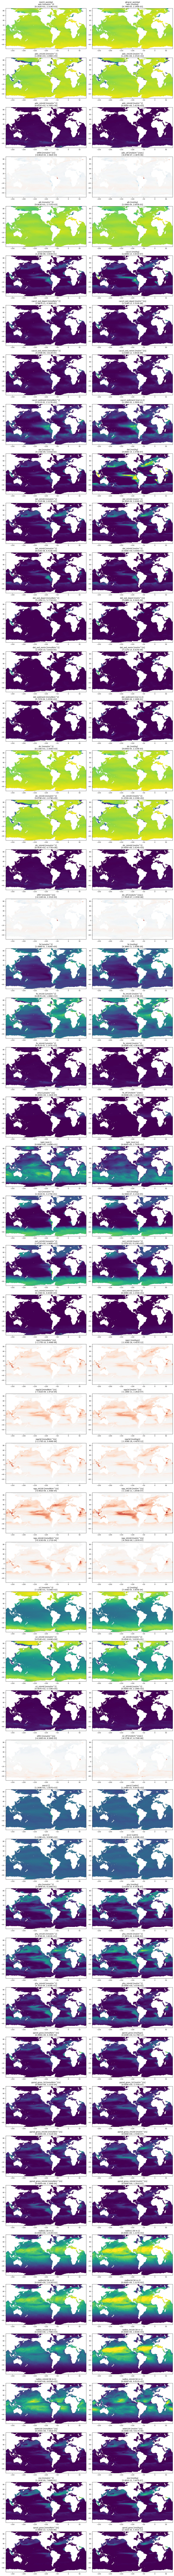

In [10]:
def clim_mean(da):
    """ Reduce input DataArray to surface climatological mean """
    month = 6
    if "st_ocean" in da.coords:
        da = da.isel(st_ocean=0)
    return da.groupby("time.month").mean("time").sel(month=month)

compare_maps(all_variables, clim_mean)

In [11]:
client.close()